In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

## Read dataset 

In [91]:
df = pd.read_csv("indian_liver_patient.csv")

# Check if data has been properly loaded
df.head(2)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1


Looking at the data, it's clear that these features were recorded probably after certain tests were run on the patients.

The features are as follows: 

- **Age** : age of the patient
- **Gender** : gender of the patient (Male/ Female)
- **Total_Bilirubin .... Albumin_and_Globulin_Ratio** : patient medical test results
- **Dataset** : if patient has disease or not ( 1: have_disease , 2: otherwise)

Although the data is clean, we shall perform basic data cleaning like checking for missing values.

## Check for missing values

In [92]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

The second last feature (Albumin_Globulin_Ratio) has 4 NA values. We replace them with the mean of column without any loss of generality. (There are other methods, check them out [here](https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b). )

In [93]:
df.fillna(df.mean(), inplace=True)

df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

## Visualizing the data

I used the seaborn library (matplotlib based, see documentation [here](https://seaborn.pydata.org/) for most of my data visualizations.

### Pair Plots

To get a overview of the correlation between the features in the dataset, I firstly plotted a pair plot which is basically a scatter plot of all features taken pairwise.

We can immediately notice that some pairs of features are highly correlated. 

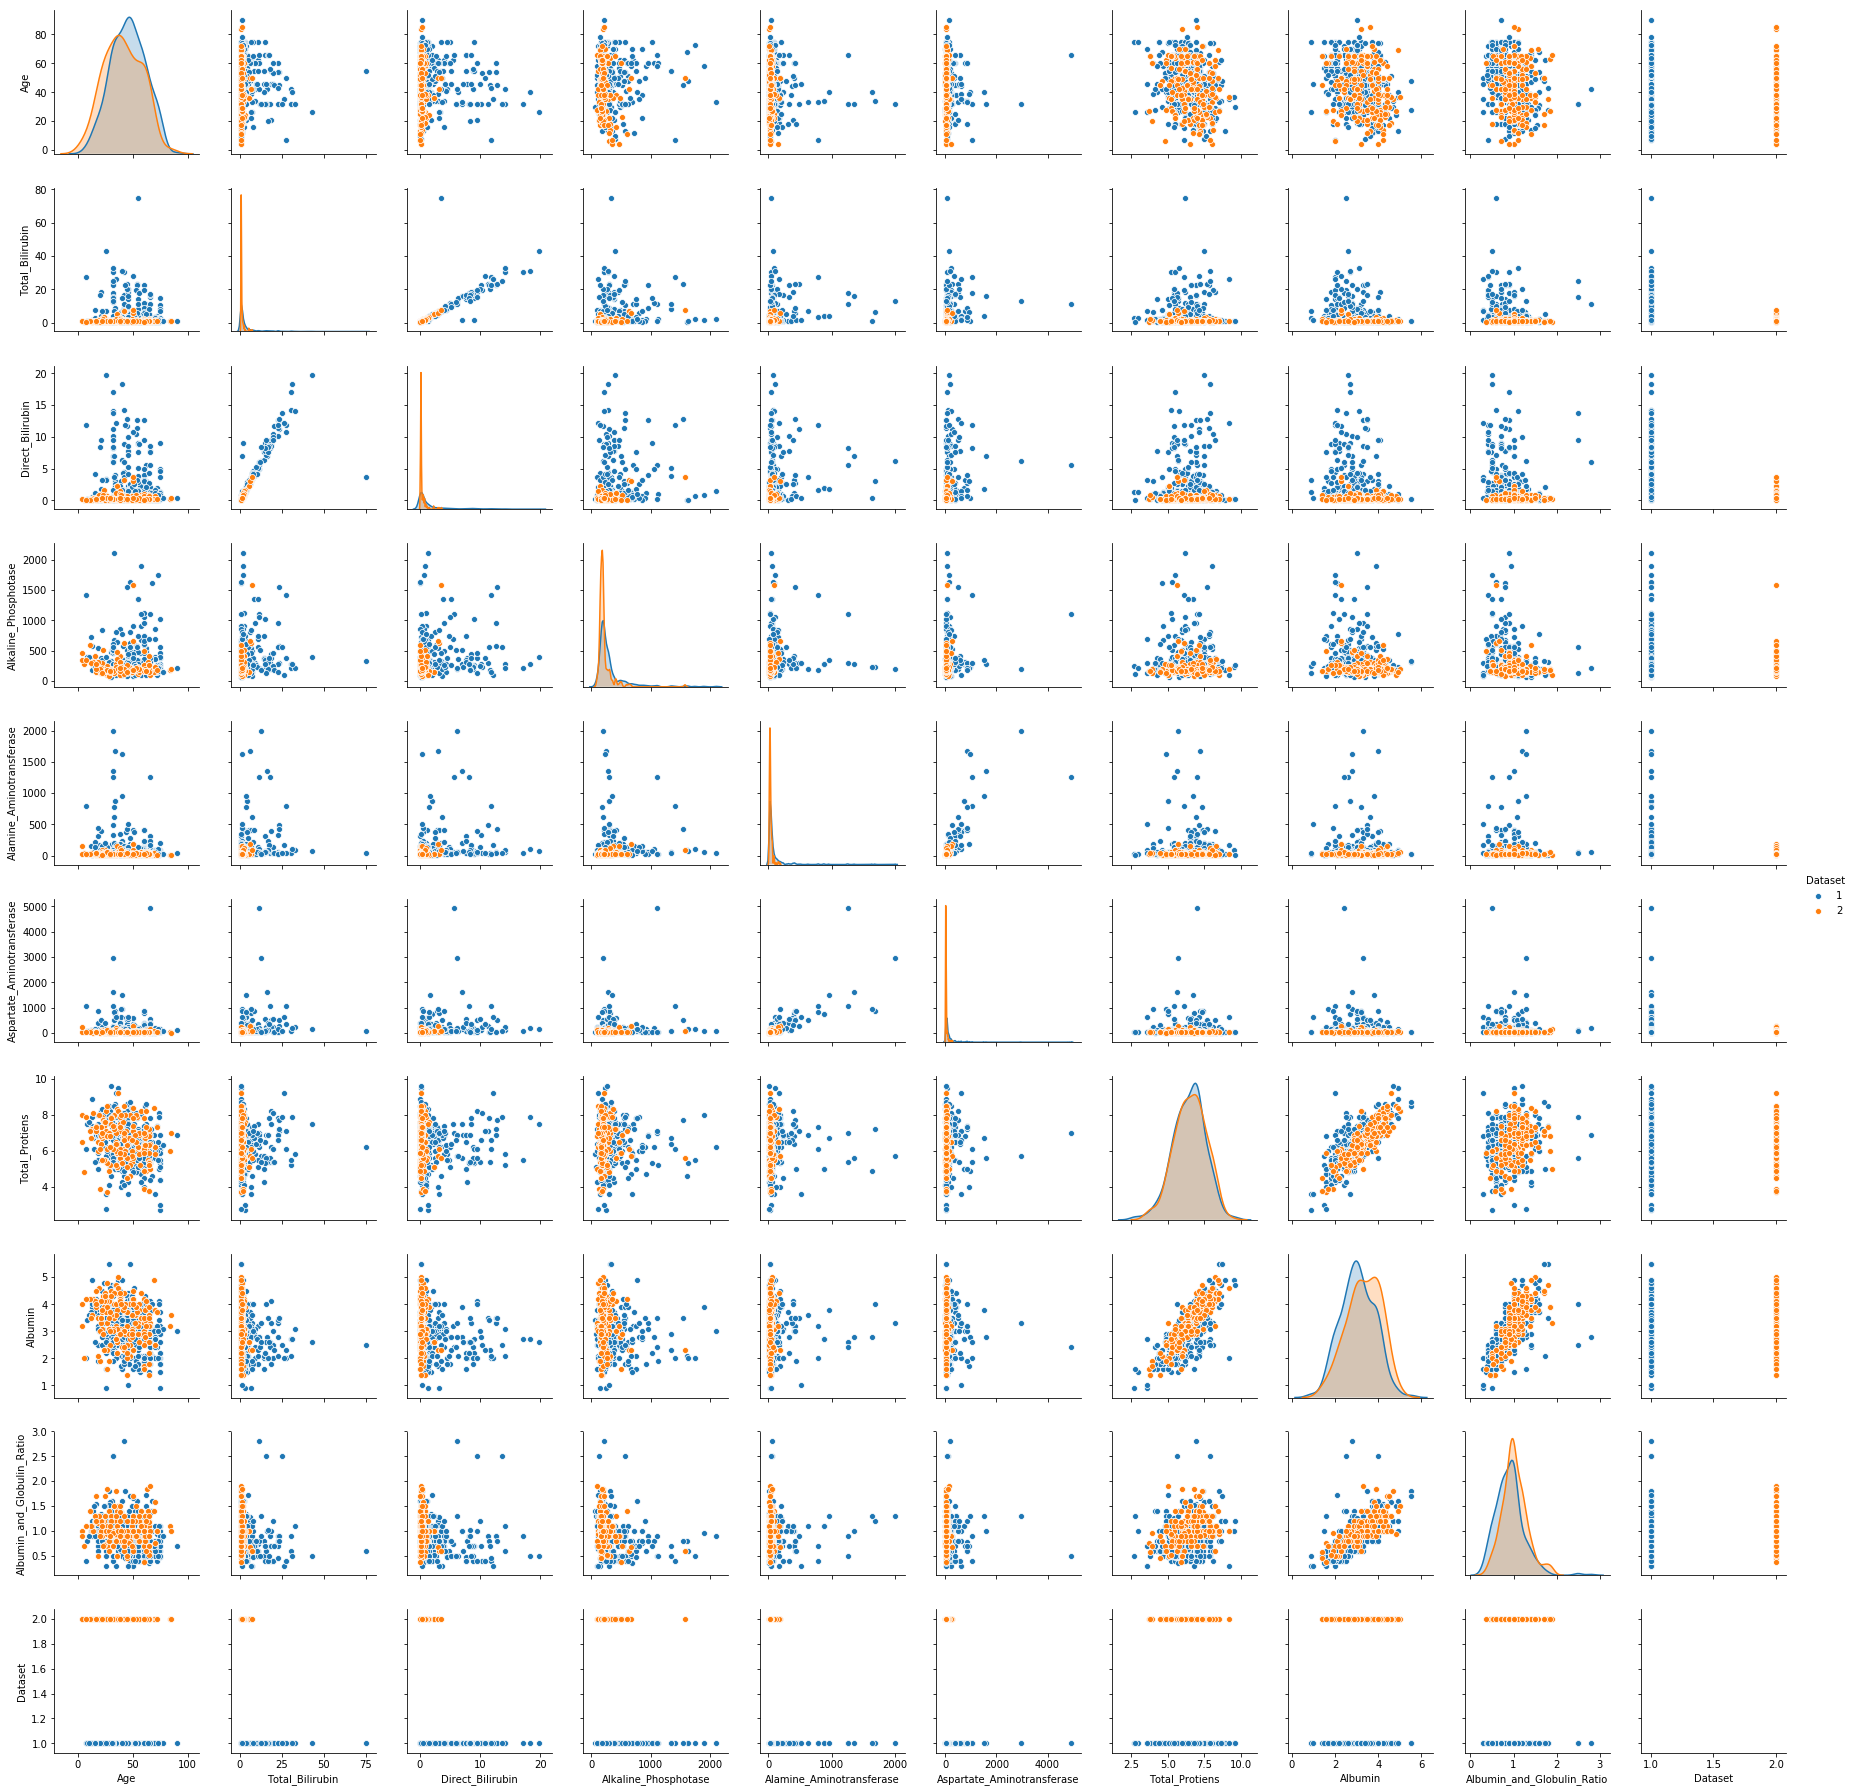

In [95]:
sns.pairplot(df, hue='Dataset')
plt.show()

### Heatmap

To get a better perspective of the correlation, I used a heatmap. The red indexes shows highly correlated features.

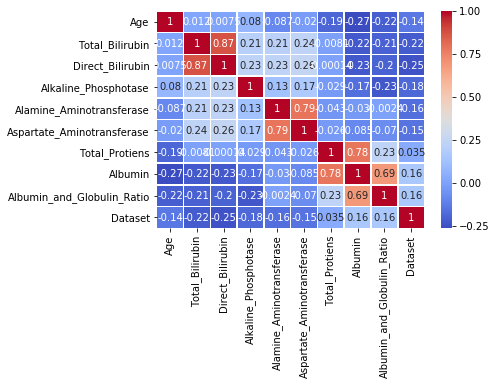

In [96]:
sns.heatmap(df.corr(),annot=True,linewidth = 0.5, cmap='coolwarm')
plt.show()

Although high correlation is not any proof of causality, it does hint towards some relation between the given features. 

The highly correlated features are: 

- Total_Bilirubin and Direct_Bilirubin
- Aspartate_Aminotransferase and Alamine_Aminotransferase
- Total_Protein and Albumin 
- Albumin and Albumin_and_Globulin_Ratio

This means that one of these features (from each pair) can be dropped without any significant drop in accuracy of the predictive model. 

Therefore, one of our set of features to be tested can be: 

- Age, Alkaline_Phosphotase, Total_Bilirubin, Aspartate_Aminotransferase, Total_Protein, Albumin_and_Globulin_Ratio
- Direct_Bilirubin, Total_Bilirubin, Alamine_Aminotransferase,Aspartate_Aminotransferase

We first test the first set of features with Decision Tree and Random Forest Classifier

In [100]:
# cols = ['Total_Bilirubin','Direct_Bilirubin','Alamine_Aminotransferase','Aspartate_Aminotransferase','Dataset']
cols = ['Age', 'Total_Bilirubin','Alkaline_Phosphotase','Aspartate_Aminotransferase', 'Total_Protiens','Albumin_and_Globulin_Ratio', 'Dataset']

dfs = df[cols]
dfs.head()

X = dfs.drop(['Dataset'],axis=1)
y = dfs.Dataset

dfs.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Aspartate_Aminotransferase,Total_Protiens,Albumin_and_Globulin_Ratio,Dataset
0,65,0.7,187,18,6.8,0.90,1
1,62,10.9,699,100,7.5,0.74,1
2,62,7.3,490,68,7.0,0.89,1
3,58,1.0,182,20,6.8,1.00,1
4,72,3.9,195,59,7.3,0.40,1


#### Split the data into training and testing sets. 

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### Scale the data using sklearn's Standard Scaler

In [102]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Linear Discriminant Analysis for feature reduction

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=3)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

##### Random Forest Classifier

In [104]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[71  7]
 [35  4]]
Accuracy: 0.6410256410256411


#### Decision Tree Classifier

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)


y_pred = clf_gini.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[72  6]
 [35  4]]
Accuracy: 0.6495726495726496


### Second feature list: 

In [106]:
cols = ['Total_Bilirubin','Direct_Bilirubin','Alamine_Aminotransferase','Aspartate_Aminotransferase','Dataset']
#cols = ['Age', 'Direct_Bilirubin','Alkaline_Phosphotase','Alamine_Aminotransferase', 'Total_Protiens','Albumin_and_Globulin_Ratio', 'Dataset']

dfs = df[cols]
dfs.head()

X = dfs.drop(['Dataset'],axis=1)
y = dfs.Dataset

dfs.head()

,Total_Bilirubin,Direct_Bilirubin,Alamine_Aminotransferase,Aspartate_Aminotransferase,Dataset
0,0.7,0.1,16,18,1
1,10.9,5.5,64,100,1
2,7.3,4.1,60,68,1
3,1.0,0.4,14,20,1
4,3.9,2.0,27,59,1


##### Splitting into training and testing data

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#### Scale numeric attributes

In [108]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Linear Discriminant Analysis for feature reduction

In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=3)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

#### Random Forest Classifier

In [110]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[75  3]
 [34  5]]
Accuracy0.6837606837606838


#### Decision Tree Classifier

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)


y_pred = clf_gini.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[75  3]
 [31  8]]
Accuracy0.7094017094017094


Therefore, the above results can be tabulated as follows:


|    Accuracy       | Random Forest  	| Decision Tree 	|
|-------------------|-------------------|-------------------|
| Feature List #1   | 64.1              | 64.95             |
| Feature List #2   | 68.37             | 70.94             |

Clearly, Feature List 2 with Decision Tree Classifier gives the highest result ( 71% ) . 


# Further Considerations

- This analysis did not take into account gender, which was also an important feature according to the visualizations above.

- More emphasis can be given to feature selection (using more detailed plots) 